# Prediction of Covid-19 from Cough Analysis


#Summary

The pandemic due to Covid-19 has been affecting the world since more than 2 years. Experts agree that mass testing is essential for isolating infected individuals, and slowing the progression of the virus. There is a need for testing method which is inexpensive, can give test result within a minute, can be done without any supervision and with limited contact with other people. Here I have taken cough audio data collected from public source to segment them into equal size with cough signal and extract the audio feture mel frequency cepstral coefficients (MFCCs) spectrograms using Librosa. I have used the extracted (MFCC) spectrogram to develop a deep learning Siamese network model to predict Covid-19 positive, symptomatic and healthy. This model can be use to develop a web app or cell phone app where people can upload their cough audio and know the test results for covid-positive or negative within minute. The model training accuracy was around 70% and validation accuracy calculated from confusion matrix was around 40%. Recall accuracy of 70%, 40% and 10% for Covid-19, symptomatic and Healthy classes respectively. From the recall value it can be seen that the model is predicting Covid-19 or symptomatic. 

#Data

The data set was obtained from publicly available database. Data of cough and other informations such as health condition was collected from people all over the world. The dataset consists of thousands of cough audio of variable length along with metadata containing labels of Covid-19, Healthy and Symptomatic. The three kinds of levels were according to self reported value as confirmed Covid-19, symptomatic but not Covid-19 and healthy. The research group also have included the cough classification score in the metadata.

## Downloading Dataset

In [ ]:
!wget https://zenodo.org/record/4498364/files/public_dataset.zip

--2022-03-25 03:15:36--  https://zenodo.org/record/4498364/files/public_dataset.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332806163 (1.2G) [application/octet-stream]
Saving to: ‘public_dataset.zip’

public_dataset.zip  100%[===================>]   1.24G  4.09MB/s    in 9m 37s  

2022-03-25 03:25:16 (2.20 MB/s) - ‘public_dataset.zip’ saved [1332806163/1332806163]



In [ ]:
!unzip public_dataset.zip

In [ ]:
!pip install -U plaidml-keras

Installation of opensource software ffmpeg to convert audio files of .webm and .ogg files to audio processable file .wav format

In [ ]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


# Segmentation

##Padding and segmenting each file into individual coughs and equal dimension 

As the audio samples collected from public were variable length, to keep the dimension of data in same length I used librosa for loading and segmenting the audio files to make all the audio sample uniform size and containing the cough segment. 

I used the segmentation method provided by the research group, which published the data collection paper.

In [ ]:
import numpy as np

In [ ]:



def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
   
    # I got this segmentation code from the original research group who published the data collection paper.
    """Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask



Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)

In [ ]:
def compute_SNR(x, fs):
    
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

## Data Preparation

##Importing Librosa,keras and other libraries for model creation, training and plotting.


In [ ]:
!pip install keras-resnet

In [ ]:
import pandas as pd
import librosa 
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
from pathlib import Path

import plaidml.keras
plaidml.keras.install_backend()
import keras
import keras.backend as L
from keras.applications.resnet50 import ResNet50
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout, Activation
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

%matplotlib inline

##Loading metadata and counting the classes

In [ ]:
data = pd.read_csv(r'public_dataset/metadata_compiled.csv')

In [ ]:
data = data[data["cough_detected"]>0.29]

In [ ]:
SAMPLE_RATE = 48000 

In [ ]:
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_CHANNELS = 1

In [ ]:
data["Filepath"] = "public_dataset/"+data["uuid"]

In [ ]:
data = data.sort_values(by="cough_detected", ascending = False)

In [ ]:
data = data[["uuid","cough_detected","Filepath","status"]]

In [ ]:
data.dropna(axis=0, inplace=True)

In [ ]:
data["status"].value_counts()

healthy        10488
symptomatic     2195
COVID-19         835
Name: status, dtype: int64

To make the dataset balanced for all the classes, I chose equal no of samples from all the classes. Covid-19 had least no of samples. So I chose sample size of 835 for all the classes.

In [ ]:
data = data.groupby('status').apply(lambda x : x.sample(835))

In [ ]:
data["status"].value_counts()

COVID-19       835
healthy        835
symptomatic    835
Name: status, dtype: int64

In [ ]:
data

uuid  cough_detected  \
status                                                                    
COVID-19    22051  cd65f53b-5d48-4b6d-8f13-5ac619d81108          0.5202   
            22164  ce8ccb5f-c7a3-48e1-839a-a9c4cd71ab3a          1.0000   
            18293  aa6fd1f1-ef61-4aba-9db6-18e625736b9f          0.7532   
            19505  b57e5d14-8c3a-415b-89a6-79befe87330c          0.5801   
            9784   5b0be374-28d0-4a16-b010-0c18a460a7d4          1.0000   
...                                                 ...             ...   
symptomatic 12609  74acb252-1606-40dd-981d-d60fe9660aeb          0.9960   
            10187  5ee6a648-fd4a-440f-abca-80b27991f444          0.9966   
            6993   412abb18-7ead-402e-a18b-7aa0d5fabf44          0.9704   
            2304   15704523-4a4e-43f0-9b25-47d6a674f9ff          1.0000   
            12097  702283b1-9cd9-4da7-8695-54f619a5daf4          0.9717   

                                                            Filepath  \
status                                                                 
COVID-19    22051  public_dataset/cd65f53b-5d48-4b6d-8f13-5ac619d...   
            22164  public_dataset/ce8ccb5f-c7a3-48e1-839a-a9c4cd7...   
            18293  public_dataset/aa6fd1f1-ef61-4aba-9db6-18e6257...   
            19505  public_dataset/b57e5d14-8c3a-415b-89a6-79befe8...   
            9784   public_dataset/5b0be374-28d0-4a16-b010-0c18a46...   
...                                                              ...   
symptomatic 12609  public_dataset/74acb252-1606-40dd-981d-d60fe96...   
            10187  public_dataset/5ee6a648-fd4a-440f-abca-80b2799...   
            6993   public_dataset/412abb18-7ead-402e-a18b-7aa0d5f...   
            2304   public_dataset/15704523-4a4e-43f0-9b25-47d6a67...   
            12097  public_dataset/702283b1-9cd9-4da7-8695-54f619a...   

                        status  
status                          
COVID-19    22051     COVID-19  
            22164     COVID-19  
            18293     COVID-19  
            19505     COVID-19  
            9784      COVID-19  
...                        ...  
symptomatic 12609  symptomatic  
            10187  symptomatic  
            6993   symptomatic  
            2304   symptomatic  
            12097  symptomatic  

[2505 rows x 4 columns]

##Feature Extraction and Saving Mel-Spectrograms

Though there are different kind of audio features can be extracted, but I chose to extract Mel-Frequency Cepstral Coefficients (MFCC). MFCCs encode timbral information. Other papers also used MFFC of cough to diagnose different kind of health conditions. 

In [ ]:
import os
from tqdm import tqdm

In [ ]:
if input()=="YES":
   import shutil
   shutil.rmtree('MFCCS')


In [ ]:
destination="MFCCS/"
os.makedirs('MFCCS/Mel_Spectrogram/COVID-19')
os.makedirs('MFCCS/MFCC1/COVID-19')


In [ ]:
os.mkdir('MFCCS/Mel_Spectrogram/healthy')
os.mkdir('MFCCS/MFCC1/healthy')

In [ ]:
os.mkdir('MFCCS/Mel_Spectrogram/symptomatic')
os.mkdir('MFCCS/MFCC1/symptomatic')

In [ ]:
def prepare_dataset(destination, sr=SAMPLE_RATE):
    for i,x in tqdm(data.iterrows()):
        filename = x["Filepath"]
        label = x["status"]
        uuid = x["uuid"]
        if label=="symptomatic":
            try:
                x, sr = librosa.load(filename+".webm", sr = sr)
            except:
                try:
                    x, sr = librosa.load(filename+".ogg", sr = sr)
                except:
                    print("File does not exist")
            cough_segments, cough_mask = segment_cough(x,sr, cough_padding=0)
            dest = destination+"Mel_Spectrogram/"+label+"/"+uuid+".png"
            if Path(dest).is_file():
                continue
            else:
                if(len(cough_segments)>0):
                    mel_spec = librosa.feature.melspectrogram(cough_segments[0] , sr = sr, n_fft = 2048, hop_length = 512, n_mels = 90)
                    log_mel_spec = librosa.power_to_db(mel_spec)
                    fig = plt.figure(figsize=(25,10))
                    librosa.display.specshow(log_mel_spec,
                                      x_axis="time",
                                      y_axis="mel",
                                      sr=SAMPLE_RATE)
                    plt.savefig(dest)
                    plt.close()
            dest = destination+"MFCC1/"+label+"/"+uuid+".png"
            if Path(dest).is_file():
                continue
            else:
                if(len(cough_segments)>0):
                    mfcc = librosa.feature.mfcc(cough_segments[0] , sr = sr, n_mfcc=13)
                    fig = plt.figure(figsize=(25,10))
                    librosa.display.specshow(mfcc,
                                      x_axis="time",
                                      sr=sr)
                    plt.savefig(dest)
                    plt.close()

In [ ]:
prepare_dataset(destination)

## Save MFCCS to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r "MFCCS/MFCC1/symptomatic" "/content/drive/My Drive/MFCC/symptomatic"

## Load Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
covid_path= '/content/drive/My Drive/MFCC/Covid/COVID-19'
healthy_path = '/content/drive/My Drive/MFCC/healthy'
symptomatic_path = '/content/drive/My Drive/MFCC/symptomatic'

## Training

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import random
import keras
from keras.models import Sequential
import time
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.layers import Dropout,Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import *
from keras.layers import Layer
from keras import backend as K
from keras.regularizers import l2
import pandas as pd
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator

##File path for MFCC spectrograms

In [ ]:
covid_model = covid_path + '/0eba0c0a-5609-4777-903d-b15292798250.png'
healthy_model = healthy_path + '/0cb18590-3107-42dc-b0ca-63b897f15a8b.png'
symptomatic_model = symptomatic_path + '/0eef6d8c-73f0-4c59-8155-3786687f5ff0.png'

##Preparing DataFrame from Spectrogram Images 

Since my Siamese Network model requires two images in each step, I created some positive pairs and some negative pair of training images. Positive pairs mean, the two images belong to the same class and negative pair means, they do not belong to the same class. Here I created the label Y as 0 for positive class and 1 for negative classes. The model predict method finds the distance between the two input images. 

In [ ]:
df = pd.DataFrame()

In [ ]:
X1 = []
X2 = []
Y = []

for file in os.listdir(covid_path):
  X1.append(covid_model)
  X2.append(os.path.join(covid_path,file))
  Y.append(0)

for file in os.listdir(healthy_path):
  X1.append(healthy_model)
  X2.append(os.path.join(healthy_path,file))
  Y.append(0)

for file in os.listdir(symptomatic_path):
  X1.append(symptomatic_model)
  X2.append(os.path.join(symptomatic_path,file))
  Y.append(0)

In [ ]:
len(X1),len(X2),len(Y)

(2231, 2231, 2231)

In [ ]:
for file in os.listdir(covid_path):
  X1.append(healthy_model)
  X1.append(symptomatic_model)
  X2.append(os.path.join(covid_path,file))
  X2.append(os.path.join(covid_path,file))
  Y.append(1)
  Y.append(1)

for file in os.listdir(healthy_path):
  X1.append(covid_model)
  X1.append(symptomatic_model)
  X2.append(os.path.join(healthy_path,file))
  X2.append(os.path.join(healthy_path,file))
  Y.append(1)
  Y.append(1)

for file in os.listdir(symptomatic_path):
  X1.append(healthy_model)
  X1.append(covid_model)
  X2.append(os.path.join(symptomatic_path,file))
  X2.append(os.path.join(symptomatic_path,file))
  Y.append(1)
  Y.append(1)

In [ ]:
len(X1),len(X2),len(Y)

(6693, 6693, 6693)

In [ ]:
(6693+2231)%16

12

In [ ]:
df["X1"] = X1
df["X2"] = X2
df["Y"] = Y

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,X1,X2,Y
0,/content/drive/My Drive/MFCC/symptomatic/0eef6...,/content/drive/My Drive/MFCC/symptomatic/3951f...,0
1,/content/drive/My Drive/MFCC/healthy/0cb18590-...,/content/drive/My Drive/MFCC/Covid/COVID-19/f7...,1
2,/content/drive/My Drive/MFCC/symptomatic/0eef6...,/content/drive/My Drive/MFCC/symptomatic/a3ca0...,0
3,/content/drive/My Drive/MFCC/symptomatic/0eef6...,/content/drive/My Drive/MFCC/Covid/COVID-19/74...,1
4,/content/drive/My Drive/MFCC/symptomatic/0eef6...,/content/drive/My Drive/MFCC/symptomatic/e8527...,0


##Data generator for training and training

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2)

In [ ]:
input_imgen = ImageDataGenerator(rescale = 1./255)

test_imgen = ImageDataGenerator(rescale = 1./255)



def generate_generator_multiple(generator,df, batch_size, img_height,img_width):
    genX1 = generator.flow_from_dataframe(df,
                                          directory = None,
                                          x_col = "X1",
                                          y_col = "Y",
                                          color_mode = "grayscale",
                                          target_size = (img_height,img_width),
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_dataframe(df,
                                          directory = None,
                                          x_col = "X2",
                                          y_col = "Y",
                                          color_mode = "grayscale",
                                          target_size = (img_height,img_width),
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            
batch_size = 32
img_height = 300
img_width = 300

inputgenerator=generate_generator_multiple(generator=input_imgen,
                                           df = train,
                                           batch_size=batch_size,
                                           img_height=img_height,
                                           img_width=img_width)

#Models

I chose Simaese network model as the sample size for each class was small. 

##Model_1

I have two Conv2 layer, one fully connected layer with 128 neurons with total 43,675,137 parameters. With this model I got training accuracy around 80% and validation accuracy around 80% for Covid-19, between 60-70% for symptomatic and around 50% for healthy classes.
 

In [ ]:
def create_model(input_shape):
  left_input = Input(input_shape)
  right_input = Input(input_shape)
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded_l, encoded_r])
  prediction = Dense(1,activation='sigmoid')(L1_distance)

 

  siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  return siamese_net

##Model_2


As there was huge difference between training (80%) and validation (65%) accuracy with model_1. To rectify the overfitting, I modified the model_1 with adding a Dropout layer and increasing neurons to 256.

In [ ]:
def create_model_2(input_shape):
  left_input = Input(input_shape)
  right_input = Input(input_shape)
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  

  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(128, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))

  model.add(Dense(256)) 
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(Dropout(0.5))

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded_l, encoded_r])
  prediction = Dense(1,activation='sigmoid')(L1_distance)

 

  siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  return siamese_net

In [ ]:
#from keras import backend

In [ ]:
model=create_model((300, 300, 1))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          43675008    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
model_2=create_model_2((300, 300, 1))
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          80510080    ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [ ]:
#model_2 optimization
optimizer = Adam(learning_rate = 0.0001)
model_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')

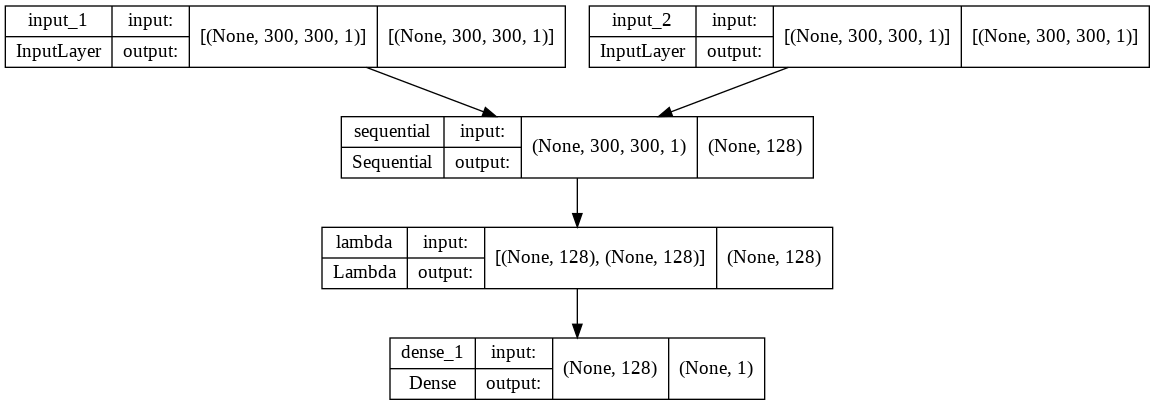

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Ran 30 epochs in cycle of 20 and 10

In [ ]:
history=model.fit(inputgenerator,
                        steps_per_epoch=len(train)/batch_size,
                        epochs = 5,
                        use_multiprocessing=True,                        shuffle=True)

In [ ]:
# fitting model_2
history=model_2.fit(inputgenerator,
                        steps_per_epoch=len(train)/batch_size,
                        epochs = 5,
                        use_multiprocessing=True,  shuffle=True)

Found 5354 validated image filenames.
Found 5354 validated image filenames.
Epoch 1/5
167/167 [==============================] - 2681s 16s/step - loss: 0.8870 - accuracy: 0.5205
Epoch 2/5
167/167 [==============================] - 2667s 16s/step - loss: 0.7949 - accuracy: 0.5874
Epoch 3/5
 85/167 [==============>...............] - ETA: 21:47 - loss: 0.7486 - accuracy: 0.6099

In [ ]:
model.save('/content/drive/My Drive/MFCC/saved_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/MFCC/saved_model/assets




#Testing

During testing an anchor image is randomly chosen from each class and distance is measured between the features or vectors of these anchor and test image learned by two subnetworks. This way, we get 3 distance scores for each test image and we find out which class gave us the lowest score. That class is assumed to be the predicted class for our test image. 

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import random
import keras
from keras.models import Sequential
import time
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import *
from keras.layers import Layer
from keras import backend as K
from keras.regularizers import l2
import pandas as pd
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model =keras.models.load_model('/content/drive/My Drive/MFCC/saved_model')

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

##  Test folder with test files from each class

In [ ]:
test_folder = '/content/drive/My Drive/MFCC/Test'

In [ ]:
test_df = pd.DataFrame()

In [ ]:
covid_path= '/content/drive/My Drive/MFCC/Covid/COVID-19'
healthy_path = '/content/drive/My Drive/MFCC/healthy'
symptomatic_path = '/content/drive/My Drive/MFCC/symptomatic'

In [ ]:
covid_model = covid_path + '/0eba0c0a-5609-4777-903d-b15292798250.png'
healthy_model = healthy_path + '/0cb18590-3107-42dc-b0ca-63b897f15a8b.png'
symptomatic_model = symptomatic_path + '/0eef6d8c-73f0-4c59-8155-3786687f5ff0.png'

In [ ]:
anchor = []
testing = []
label = []
for folder in os.listdir(test_folder):
  foldern = os.path.join(test_folder,folder)
  for file in os.listdir(foldern):
    filename = os.path.join(foldern,file)
    if folder=="COVID-19":
      anchor.append(covid_model)
      testing.append(filename)
      label.append(0)
      anchor.append(healthy_model)
      anchor.append(symptomatic_model)
      testing.append(filename)
      testing.append(filename)
      label.append(1)
      label.append(1)
    if folder=="symptomatic":
      anchor.append(symptomatic_model)
      testing.append(filename)
      label.append(0)
      anchor.append(healthy_model)
      anchor.append(covid_model)
      testing.append(filename)
      testing.append(filename)
      label.append(1)
      label.append(1)
    if folder=="healthy":
      anchor.append(healthy_model)
      testing.append(filename)
      label.append(0)
      anchor.append(covid_model)
      anchor.append(symptomatic_model)
      testing.append(filename)
      testing.append(filename)
      label.append(1)
      label.append(1)

In [ ]:
len(label)

90

In [ ]:

def generate_generator_multiple(generator,df, batch_size, img_height,img_width):
    genX1 = generator.flow_from_dataframe(df,
                                          directory = None,
                                          x_col = "X1",
                                          y_col = "Y",
                                          color_mode = "grayscale",
                                          target_size = (img_height,img_width),
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_dataframe(df,
                                          directory = None,
                                          x_col = "X2",
                                          y_col = "Y",
                                          color_mode = "grayscale",
                                          target_size = (img_height,img_width),
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label

In [ ]:
test_df["X1"] = anchor
test_df["X2"] = testing
test_df["Y"] = label

In [ ]:
testgenerator=generate_generator_multiple(test_imgen,
                                          df = test_df,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height)

In [ ]:
pred = model.predict(testgenerator, steps = len(test_df)/batch_size)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [ ]:
test_df["preds"] = pred

In [ ]:
data = test_df[["Y","preds"]].head(30)

In [ ]:
prediction = [1]*90

For each test image distance prediction (preds column in test_df) I gave value 'zero' or 1 (prediction column). 'zero' corresponds to minimum distance and 1 correspond to other two values of distance for that test image. Comparing 'Y' column with 'prediction' column can give us idea about the accuracy of the prediction of the model. 

In [ ]:
for i in range(0,len(pred),3):
  value0 = pred[i]
  value1 = pred[i+1]
  value2 = pred[i+2]
  li = (value0,value1,value2)
  index = li.index(min(li))
  pos = i + index
  prediction[pos] = 0

In [ ]:
test_df["prediction"] = prediction

In [ ]:
true = test_df["Y"]

In [ ]:
test_df

,X1,X2,Y,preds,prediction
0,/content/drive/My Drive/MFCC/Covid/COVID-19/0e...,/content/drive/My Drive/MFCC/Test/COVID-19/1d4...,0,0.975780,1
1,/content/drive/My Drive/MFCC/healthy/0cb18590-...,/content/drive/My Drive/MFCC/Test/COVID-19/1d4...,1,0.986449,1
2,/content/drive/My Drive/MFCC/symptomatic/0eef6...,/content/drive/My Drive/MFCC/Test/COVID-19/1d4...,1,0.789488,0
3,/content/drive/My Drive/MFCC/Covid/COVID-19/0e...,/content/drive/My Drive/MFCC/Test/COVID-19/1c8...,0,0.951542,1
4,/content/drive/My Drive/MFCC/healthy/0cb18590-...,/content/drive/My Drive/MFCC/Test/COVID-19/1c8...,1,0.989270,1
...,...,...,...,...,...
85,/content/drive/My Drive/MFCC/Covid/COVID-19/0e...,/content/drive/My Drive/MFCC/Test/healthy/2bc3...,1,0.993233,1
86,/content/drive/My Drive/MFCC/symptomatic/0eef6...,/content/drive/My Drive/MFCC/Test/healthy/2bc3...,1,0.641580,0
87,/content/drive/My Drive/MFCC/healthy/0cb18590-...,/content/drive/My Drive/MFCC/Test/healthy/2baa...,0,0.979808,1
88,/content/drive/My Drive/MFCC/Covid/COVID-19/0e...,/content/drive/My Drive/MFCC/Test/healthy/2baa...,1,0.959415,1


creating confusion matrix from ground truth and predicted value.

In [ ]:
class_index_dict={
    'COVID-19':0,'symptomatic':1,'healthy':2
}

In [ ]:
ground_truths=[]
for i in range(0,len(pred),3):
  ground_truths.append(test_df['X2'][i].split('/')[-2])
ground_truths=[class_index_dict[x] for x in ground_truths]
print(ground_truths)

In [ ]:
predicted_classes=[]
for i in range(0,len(pred),3):
  value0 = pred[i]
  value1 = pred[i+1]
  value2 = pred[i+2]
  li = (value0,value1,value2)
  index = li.index(min(li))
  pos = i + index
  predicted_classes.append(test_df['X1'][pos].split('/')[-2])
predicted_classes=[class_index_dict[x] for x in predicted_classes]
print(predicted_classes)


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_vis_1=confusion_matrix(ground_truths,predicted_classes)

#confusion matrix for model_1

#confusion matrix for model_2 

0:Covid-19, 1:symptomatic, 2: healthy 

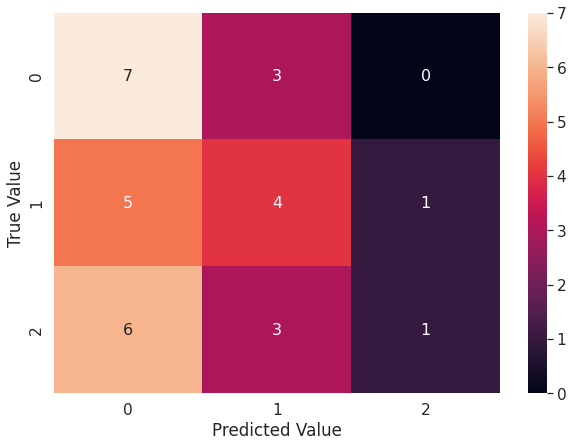

In [ ]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
fig=sns.heatmap(confusion_vis,annot=True, annot_kws={"size": 16}) # font size
fig.set( xlabel = "Predicted Value", ylabel = "True Value")
plt.show()

In [ ]:
print("Accuracy is {}".format(accuracy_score(test_df["Y"].to_list(),test_df["prediction"].to_list())))

#Visualization of Confusion Matrix

With label "0" and "1"

In [ ]:
test_vis= confusion_matrix(test_df["Y"].to_list(),test_df["prediction"].to_list())

In [ ]:
test_vis

array([[12, 18],
       [18, 42]])

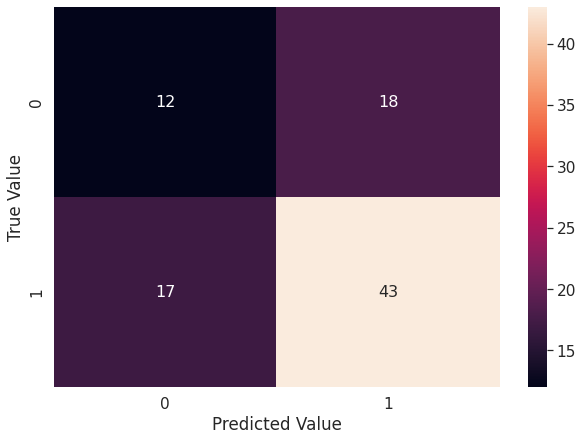

In [ ]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
fig=sns.heatmap(test_vis,annot=True, annot_kws={"size": 16}) # font size
fig.set( xlabel = "Predicted Value", ylabel = "True Value")
plt.show()

In [ ]:
model_report= classification_report(test_df["Y"].to_list(),test_df["prediction"].to_list())


In [ ]:
print(model_report)

              precision    recall  f1-score   support

           0       0.41      0.40      0.41        30
           1       0.70      0.72      0.71        60

    accuracy                           0.61        90
   macro avg       0.56      0.56      0.56        90
weighted avg       0.61      0.61      0.61        90



#Result

With model_2 the training accuracy of 72% with the new model while the validation accuracy was 62%. model_2 didn't improve the accuracy for classes but overfitting reduced. Recall of Covid-19 was 80% for both the models. symptomatic class had close to 60% recall, where as healthy class has the least recall of around 50%.

##Recall Value 

In [ ]:
def print_recall(check):
  correct = 0
  total = 0
  for _,x in test_df.iterrows():
    category = x["X2"].split("/")[-2]
    truth = x["Y"]
    pre = x["prediction"]
    if category==check:
      total+=1
      if truth==pre:
        correct+=1
  accuracy = correct/total
  print("Recall of {} is {} ".format(check,accuracy))

In [ ]:
print_recall("COVID-19")

Recall of COVID-19 is 0.8 


In [ ]:
print_recall("healthy")

Recall of healthy is 0.4 


In [ ]:
print_recall("symptomatic")

Recall of symptomatic is 0.6 
